# Laboratory No. 3. Statistical Inference
# Excercise 1:
# Gaussian Model Fitting using MC Methods
### presented by: Juan David Gil and Juan Sebastián Silva
### Date: 18 March 2016

In [112]:
% pylab inline
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab as pb
from matplotlib import cm
from scipy import stats
from scipy.stats import norm
from scipy.special import gamma as gammafun
from scipy.stats import chi
from scipy.stats import multivariate_normal
from scipy.stats import gamma

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Using a closed form

## Fitting a Gaussian model with unkown mean 

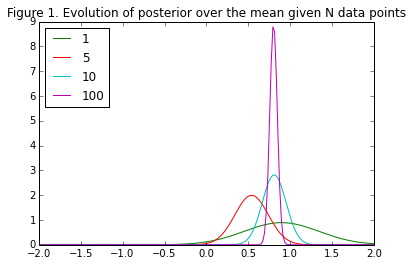

In [177]:
mean_real = 0.8 # Real mean of the
var_real = 0.2 # Real variance of the data
N = 100
X_eval = np.linspace(-2.0,2.0,200)
mean_prior = 0.5 # Prior mean for the distribution over the mean
var_prior = 50.0 # Prior variance for the distribution over the variance
n_dat = [1,5,10,100]
Y = norm.pdf(X_eval, mean_real, np.sqrt(var_real))
Y = norm.pdf(X_eval, mean_prior, var_prior)
pb.title('Figure 1. Evolution of posterior over the mean given N data points')
pb.plot(X_eval,Y)
for n in n_dat:
    X = np.random.normal(mean_real, np.sqrt(var_real), n)
    mean_ml = (1.0/n)*np.sum(X)
    posterior_mean = ((var_real/(n*var_prior + var_real))*mean_prior) + ((n*var_prior/(n*var_prior + var_real))*mean_ml)
    posterior_var = (var_prior*var_real)/((n*var_prior) + var_real)
    y = norm.pdf(X_eval, posterior_mean, np.sqrt(posterior_var))
    mlabel = str(n)
    pb.plot(X_eval, y, label=mlabel)
    pb.legend(loc='upper left')

##Fitting a Gaussina model with unknown mean and variance(Precision) 

In [3]:
np.random.seed(2)
def showNormalGamma(a_n, b_n, mean_prior, beta_prior, title, m=20, tolerance_mean=1.0, tolerance_lambda=1.0):
    #m = 20
    if(beta_prior - tolerance_lambda < 0.0):
        mlow = 0.1
    else:
        mlow = beta_prior - tolerance_lambda
    mhigh = beta_prior + tolerance_lambda
    m_lambda = np.linspace(mlow, mhigh, m)
    
    mlow = mean_prior - tolerance_mean
    mhigh = mean_prior + tolerance_mean
    m_mean = np.linspace(mlow, mhigh, m)
    
    z = np.zeros((m,m))
    i = 0
    #print (a_n-0.5)/b_n
    for t_lambda in m_lambda:
        j = 0
        mgamma = gamma(a_n)
        result_gamma = (1.0/mgamma)*(b_n**a_n)*(t_lambda**(a_n-1.0))*np.exp(-1.0*b_n*t_lambda)
        for t_mean in m_mean:
            mvar = 1.0/(beta_prior*t_lambda)
            y = multivariate_normal.pdf(t_mean, mean=mean_prior, cov=mvar)
            z[j,i] = y*result_gamma
            j+=1
        i+=1
    pb.title(title + ' over the mean and precision')
    #pb.imshow(z, extent=[8.0,12.0,-1.0,1.0])
    pb.contourf(m_lambda, m_mean, z)
    return
    


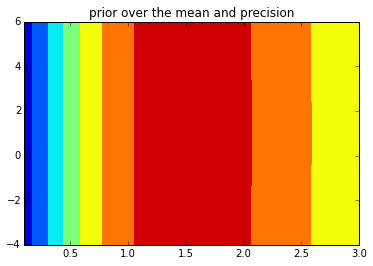

In [4]:
beta_prior = 0.0001
mean_prior = 1.0
a_n = 2.0
b_n = 1.0
showNormalGamma(a_n, b_n, mean_prior, beta_prior, 'prior', 20, 5.0, 3.0)

In [5]:
real_mean = 0.5
precision = 0.1
real_var = 1.0/precision
np.random.seed(2)
N = 10000
X = np.random.normal(real_mean, np.sqrt(real_var), N)
mean_ml = np.sum(X)/N
mean_posterior = (beta_prior*mean_prior + N*mean_ml)/(beta_prior + N)
beta_posterior = beta_prior + N
a_n = a_n + (N/2.0)
b_n = b_n + (0.5*(np.dot(X - mean_ml, X - mean_ml))) + ((beta_prior*N*(mean_ml - mean_prior)*(mean_ml - mean_prior))/2.0*(beta_prior + N))
exp_lambda = a_n/b_n
print 'Real mean: ', real_mean, ' Real precision : ', precision
print 'Posterior_mean: ', mean_posterior, ' Posterior Precision: ', exp_lambda

Real mean:  0.5  Real precision :  0.1
Posterior_mean:  0.439310704366  Posterior Precision:  0.0969105734081


The values found by the closed form for the mean and the posterior are very close to the real values, the idea now is to use the sampling methods to match the compare them with the closed form, the next method is the rejection sampling method.

# Using sampling methods

## Rejection Sampling 

### Rejection Sampling: Unknown mean and know variance

First lets define some functions that will help with some computations. First the parzen method, that will help with the drawing of the distribution given the samples generated by rejection or any other method. This parzen is only for one dimention.

In [178]:
def parzen(x, samples, h2, N):
    N = np.size(samples)
    ret = np.zeros(np.size(x))
    for i in xrange(N):
        ret += multivariate_normal.pdf(x, samples[i], h2)
    return ret / N

Next the some functions required for computing the Rejection Sampling, it's neccesary to compute the likelihood in the maximum value to know what will be the value of k using to reject the samples generated.

In [179]:
def likelihood_gaussian(X_ev, mu, sigma, flag=0):
    ret = np.copy(mu)
    for i in range(0,mu.shape[0]):
        tmp = norm.pdf(X_ev, mu[i], np.sqrt(sigma))
        #print tmp.shape
        ret[i] = np.asscalar(np.prod(tmp))
    return ret

def compute_k(X_ev, var_real, flag=0):
    k = np.sum(X_ev)/X_ev.shape[0]
    ml_mean = np.zeros(1)
    ml_mean[0] = np.asscalar(k)
    ret = likelihood_gaussian(X_ev, ml_mean, var_real)
    return np.asscalar(ret)

def get_samples_reject(X, number, var_real, flag=0):
    prop_samples = np.random.normal(mu0, np.sqrt(var0), number)
    k = compute_k(X, var_real)
    uniform_samples = np.random.uniform(size=number) * k * norm.pdf(prop_samples, mu0, np.sqrt(var0))
    cond = uniform_samples <= np.multiply(likelihood_gaussian(X, prop_samples, var_real),norm.pdf(prop_samples, mu0, np.sqrt(var0)))
    return prop_samples[cond]

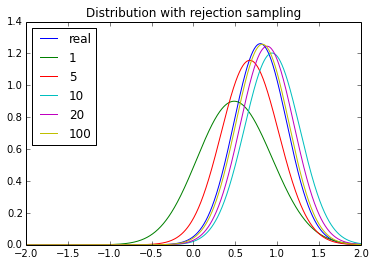

In [230]:
mu0 = 0.0 # Mean of the prior for the mean
var0 = 10.0 # Variance of the prior for the mean
mean_real = 0.8 # Real mean for generating the data
var_real = 0.1 # Real variance for generating data
N = 20 # Amount of data
M = 1000 # Amount of desired(not actual) samples
n_dat = [1,5,10,20,100]
X_eval = np.linspace(-2.0,2.0, 1000)
Y = norm.pdf(X_eval, mean_real, np.sqrt(var_real))
pb.plot(X_eval, Y, label='real')
for n in n_dat:
    X = np.random.normal(mean_real, np.sqrt(var_real), n)
    Z = get_samples_reject(X, M, var_real)    
    P_Z = parzen(X_eval, Z, 0.1, 1000)
    bestest = P_Z
    pb.title('Distribution with rejection sampling')
    mlabel = str(n)
    pb.plot(X_eval, P_Z, label=mlabel)
    pb.legend(loc='upper left')


With rejection sampling one can have a very good estimation for the mean, with 100 data points the approximation with rejection sampling is similar to the one with the closed form, the mean is close to 0.8, which is the real mean used to generate the data points, the variance is different though.

### Rejection Sampling: Unknown mean and unknow variance(precision)

In [331]:
def likelihood_gaussian_mult(X_ev, mu, mlambda, flag=0):
    ret = np.copy(mu)
    for i in range(0, mlambda.shape[0]):
        tmp = norm.pdf(X_ev, mu[i], np.sqrt(1.0/mlambda[i]))
        ret[i] = np.asscalar(np.prod(tmp))
    return ret

def getNormalGammaSamples(nsamples, mu_mean0, a, b):
    lambda_samples = np.random.gamma(a,b, nsamples)
    mean_samples = np.zeros(nsamples)
    for i in range(0,lambda_samples.shape[0]):
        mean_samples[i] = np.random.normal(mu_mean0, np.sqrt(1.0/lambda_samples[i]), 1)
    ret = np.vstack((mean_samples, lambda_samples))
    return ret.T

def normalGammaEval(mmean, mlambda, mu_mean0, a, b):
    gamma_eval = stats.gamma.pdf(mlambda, a, loc=0, scale=b)
    ret =  np.zeros(gamma_eval.shape[0])
    for i in range(0, gamma_eval.shape[0]):
        ret[i] = norm.pdf(mmean[i], mu_mean0, np.sqrt(1.0/mlambda[i]))*gamma_eval[i]
    return ret    

def compute_k_mult(X_ev,flag=0):
    ml_mean = np.sum(X_ev)/X_ev.shape[0]
    ml_variance = np.dot(X_ev - ml_mean, X_ev - ml_mean)/N
    ml_lambda = 1.0/ml_variance
    ml_mean_arr = np.zeros(1)
    ml_lambda_arr = np.zeros(1)
    ml_mean_arr[0] = ml_mean
    ml_lambda_arr[0] = ml_lambda
    ret = likelihood_gaussian_mult(X_ev, ml_mean_arr, ml_lambda_arr)
    return np.asscalar(ret)

def get_samples_reject_mult(X, number, mu_mean0, lambda_mean0, var0, a_n, b_n, flag=0):    
    prop_samples = getNormalGammaSamples(number, mu_mean0, a_n, b_n)    
    k = compute_k_mult(X)
    print k
    result_gamma = normalGammaEval(prop_samples[:,0], prop_samples[:,1], mu_mean0, a_n, b_n)
    uniform_samples = np.multiply(np.random.uniform(size=number),result_gamma)*k
    mlikelihood = likelihood_gaussian_mult(X, prop_samples[:,0], prop_samples[:,1])
    #mnormal = np.zeros(prop_samples.shape[0])
    #for i in range(0, prop_samples.shape[0]):
        #mnormal[i] = norm.pdf(prop_samples[i,0], mu_mean0, np.sqrt(1.0/prop_samples[i,1]))
    cond = uniform_samples <= np.multiply(mlikelihood, result_gamma) # REVISAR OJO!!!
    return prop_samples[cond,:]

In [333]:
mu0 = 10.0 # Mean of the prior for the mean
mean_lambda0 = 0.1 # Variance of the prior for the mean
var0 = 10.0
a = 1.0
b = 0.5

mean_real = 0.8 # Real mean for generating the data
var_real = 0.2 # Real variance for generating data
N = 20 # Amount of data
M = 10000 # Amount of desired(not actual) samples
n_dat = [1,5,10,20,100]
X_eval = np.linspace(-2.0,2.0, 1000)
X = np.random.normal(mean_real, np.sqrt(var_real), N)

#np.random.seed(2)
P_Z = get_samples_reject_mult(X, M, mu0, mean_lambda0, var0, a, b)

7.90986699923e-05


In [360]:
print P_Z.shape
# REVISAR, AUN NO ESTA COGIENDO NINGUNA MUESTRA, ES EL UNICO QUE FALLA
# Space to draw samples and check if the mean and precision are close to the posterior

(100000, 2)


## Sampling Importance Resampling(SIR)

### SIR: With unknown mean

First the sampling importance part is realized, the weights are calculated in which the importance of each sample of the proposal is given, in this case the proposal is a gaussian distribution also, because the real distribution with which the data was generated is also Gaussian.

In [184]:
mu0 = 0.0
var0 = 5.0
mean_real = 0.8
var_real = 0.1
N = 100
M = 1000
X = np.random.normal(mean_real, np.sqrt(var_real), N)

def likelihood_gaussian(X_ev, mu, sigma):
    ret = np.copy(mu)
    for i in range(0,mu.shape[0]):
        tmp = norm.pdf(X_ev, mu[i], np.sqrt(sigma))
        #print tmp.shape
        ret[i] = np.asscalar(np.prod(tmp))
    return ret

N = 20000
prop_samples = np.random.normal(mu0, np.sqrt(var0), N)
mnum = np.divide(likelihood_gaussian(X, prop_samples, var_real), norm.pdf(prop_samples, mu0, np.sqrt(var0)))
mdem = np.sum(mnum)
W_l = mnum * (1.0/mdem) 

Then comes the resampling part, for this step a sample from a multinomial experiment with probabilites W_l, then the samples generated from the proposal are chosen with the index given by the multinomial experiment, in total there are M experiments.

In [185]:
# Multinomial sampling
M = 10000
new_samples = np.zeros(M)
for i in range(0,M):
    idx = np.random.multinomial(1, W_l, 1)
    idx = np.array(idx, dtype=bool)
    idx = idx.flatten()
    new_samples[i] = np.asscalar(prop_samples[idx])

After the resampling a validation of the distribution  from the SIR samples is done in order to verify the accuracy of the method, in this case is very good.

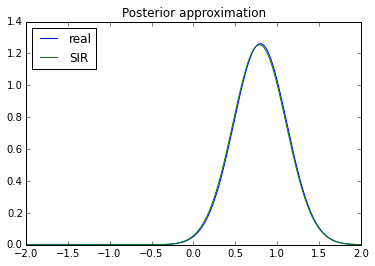

In [187]:
P_Z = parzen(X_eval, new_samples, 0.1, M)
X_eval = np.linspace(-2.0,2.0, 1000)
Y = norm.pdf(X_eval, mean_real, np.sqrt(var_real))
pb.plot(X_eval, Y, label='real')
pb.plot(X_eval, P_Z, label='SIR')
pb.title('Posterior approximation')
pb.legend(loc='upper left')

The mean is almos the closely to the same used to generate the data, in this case the curve with SIR samples almost matches the one of the real distribution curve because the h value used in parzen is the same variance of the real distribution, the important thing is that the mean of the posterior approximated with sampling is the one required.

### SIR: With unknown mean and variance

Similar process to the one above is repeated, nevertheless the proposal distribution needs to be changed, now is going to be a normal gamma distribution. 

In [252]:
mu0 = 0.0
var0 = 5.0
mean_real = 0.8
var_real = 0.1

N = 100
M = 1000
X = np.random.normal(mean_real, np.sqrt(var_real), N)

def likelihood_gaussian(X_ev, mu, sigma):
    ret = np.copy(mu)
    for i in range(0,mu.shape[0]):
        tmp = norm.pdf(X_ev, mu[i], np.sqrt(1.0/sigma[i]))
        #print tmp.shape
        ret[i] = np.asscalar(np.prod(tmp))
    return ret

N = 20000
prop_samples_prec = np.random.gamma(2.0, 2.0, N)
prop_samples_mean = np.zeros(N)

for i in range(0,N):
    prop_samples_mean[i] = np.random.normal(mu0, np.sqrt(1.0/prop_samples_prec[i]))
    
mnum = likelihood_gaussian(X, prop_samples_mean, prop_samples_prec)
mdem = np.sum(mnum)
W_l = mnum * (1.0/mdem)
print np.sum(W_l), 'Check if the sum of the weights is equal to 1.0'

1.0 Check if the sum of the weights is equal to 1.0


In [253]:
# Multinomial sampling
M = 10000
new_samples_mean = np.zeros(M)
new_samples_prec = np.zeros(M)
for i in range(0,M):
    idx = np.random.multinomial(1, W_l, 1)
    idx = np.array(idx, dtype=bool)
    idx = idx.flatten()
    new_samples_mean[i] = np.asscalar(prop_samples_mean[idx])
    new_samples_prec[i] = np.asscalar(prop_samples_prec[idx])

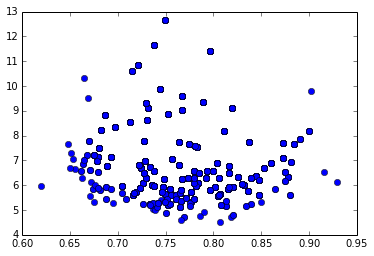

In [254]:
pb.plot(new_samples_mean, new_samples_prec, 'bo')

## Metropolis hastings Sampling

### MH: With unknown mean

In [257]:
def likelihood_gaussian(X_ev, mu, sigma, flag=0):
    ret = np.copy(mu)
    for i in range(0,mu.shape[0]):
        tmp = norm.pdf(X_ev, mu[i], np.sqrt(sigma))
        #print tmp.shape
        ret[i] = np.asscalar(np.prod(tmp))
    return ret

def metropolisHastingSample(X, n_samples, var_real, mean_prop=0.0, variance_prop=1.0):        
    z_ant = np.asscalar(np.random.normal(mean_prop, variance_prop, 1))    
    z_samples = np.zeros(n_samples)
    z_samples[0] = z_ant
    mean_ml = np.zeros(1)
    mean_ml[0] = np.sum(X)/X.shape[0]
    for i in range(1, n_samples):
        z_p = np.asscalar(np.random.normal(z_ant, variance_prop, 1))        
        mix1 = np.multiply(likelihood_gaussian(z_p, mean_ml, var_real),norm.pdf(z_p, mu0, np.sqrt(var0)))
        mix2 = np.multiply(likelihood_gaussian(z_ant, mean_ml, var_real),norm.pdf(z_ant, mu0, np.sqrt(var0)))
        mnum = norm.pdf(z_ant, z_p, variance_prop)
        mdem = norm.pdf(z_p, z_ant, variance_prop)
        mnum = mnum*mix1
        mdem = mdem*mix2
        tmp_val = mnum/mdem
        a = min(tmp_val, 1.0)
        u0 = np.asscalar(np.random.uniform(size=1))
        if(u0 <= a):
            z_samples[i] = z_p
        else:
            z_samples[i] = z_ant
        z_ant = z_samples[i]
    return z_samples

In [261]:
mu0 = 0.0
var0 = 5.0
mean_real = 0.8
var_real = 0.1
N = 100
M = 10000
X = np.random.normal(mean_real, np.sqrt(var_real), N)
P_Z = metropolisHastingSample(X, M, var_real, variance_prop=10.0)

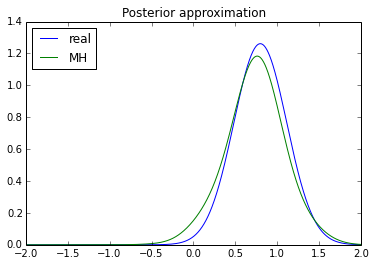

In [262]:
X_eval = np.linspace(-2.0,2.0, 1000)
Y = norm.pdf(X_eval, mean_real, np.sqrt(var_real))
pdf_hast = parzen(X_eval, P_Z, 0.04, M)
pb.plot(X_eval, Y, label='real')
pb.plot(X_eval, pdf_hast, label='MH')
pb.title('Posterior approximation')
pb.legend(loc='upper left')

The approximation with metropolis is good, the mean is approximately 0.8, the same as the one used to generate the data. Although the SIR is the best fit por the mean.

### MH: With unknown mean and variance

In [357]:
def getNormalGammaSamplesMH(nsamples, mu_mean0, mlambda, a, b):
    lambda_samples = np.random.gamma(a,b, nsamples)    
    mean_samples = np.zeros(nsamples)
    for i in range(0,mlambda.shape[0]):
        mean_samples[i] = np.random.normal(mu_mean0, np.sqrt(1.0/mlambda[i]), 1)
    ret = np.vstack((mean_samples, lambda_samples))
    return ret.T

def metropolisHastingSampleMult(X, n_samples, mean_prop, a_n, b_n):        
    z_ant = getNormalGammaSamples(1, mean_prop, a_n, b_n)
    z_samples = np.zeros((n_samples,2))
    z_samples[0,:] = z_ant
    mean_ml = np.zeros(1)
    mean_ml[0] = np.sum(X)/X.shape[0]
    for i in range(1, n_samples):
        mmean_ev = np.zeros(1)
        mlambda_ev = np.zeros(1)
        mmean_ev[0] = z_ant[0,0]
        mlambda_ev[0] = z_ant[0,1]
        z_p = getNormalGammaSamplesMH(1, mmean_ev, mlambda_ev, a_n, b_n)# Generate the sample for        
        
        
        mmean_ev[0] = z_p[0,0]
        mlambda_ev[0] = z_p[0,1]
        ng = normalGammaEval(mmean_ev, mlambda_ev, mean_prop, a_n, b_n)
        lk = likelihood_gaussian_mult(X, mmean_ev, mlambda_ev)
        mix1 = ng*lk
        mnum = ng*mix1
        
        mmean_ev[0] = z_ant[0,0]
        mlambda_ev[0] = z_ant[0,1]
        ng = normalGammaEval(mmean_ev, mlambda_ev, mean_prop, a_n, b_n)
        lk = likelihood_gaussian_mult(X, mmean_ev, mlambda_ev) 
        mix2 = ng*lk       
        mdem = ng*mix2
        
        tmp_val = mnum/mdem
        a = min(tmp_val, 1.0)
        u0 = np.asscalar(np.random.uniform(size=1))
        if(u0 <= a):
            z_samples[i,:] = z_p
            z_ant = z_p
        else:
            z_samples[i,:] = z_ant
    return z_samples

In [358]:
mu0 = 0.0
a = 2.0
b = 2.0

mean_real = 0.8
var_real = 0.1
N = 100
M = 100000
X = np.random.normal(mean_real, np.sqrt(var_real), N)
P_Z = metropolisHastingSampleMult(X, M, mu0, a, b)

(100000, 2)


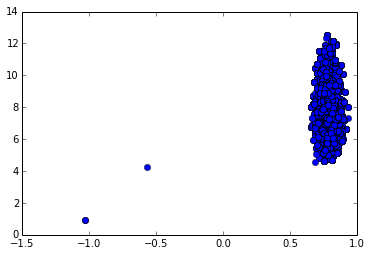

In [359]:
print P_Z.shape
pb.plot(P_Z[:,0], P_Z[:,1], 'bo')

One can see that the data group in the x-axis(mean), nevertheless with the precision(y axis) it's not the same, the data tries to group in this axis close to a number between 8 and 10, not exactly the same used to generate the data that was 10.0.